In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20241020',
'user':'student',
'password':'dpo_python_2020'
}#

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2024-09-27' and '2024-10-03'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

In [4]:
df = ph.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


Проведем небольшой EDA анализ

In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19897 entries, 0 to 19896
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_group  19897 non-null  int8   
 1   user_id    19897 non-null  uint32 
 2   likes      19897 non-null  uint64 
 3   views      19897 non-null  uint64 
 4   ctr        19897 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 563.6 KB


In [7]:
df.describe() 

,exp_group,user_id,likes,views,ctr
count,19897.000000,19897.000000,19897.000000,19897.000000,19897.000000
mean,1.496406,75513.142584,13.690255,66.793838,0.216440
std,0.500000,53254.926058,10.879688,45.364754,0.116613
min,1.000000,206.000000,0.000000,1.000000,0.000000
25%,1.000000,21945.000000,6.000000,32.000000,0.119403
50%,1.000000,109319.000000,11.000000,57.000000,0.200000
75%,2.000000,126146.000000,19.000000,91.000000,0.291667
max,2.000000,140740.000000,93.000000,341.000000,0.900000


In [8]:
df.groupby('exp_group')['user_id'].nunique() 

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

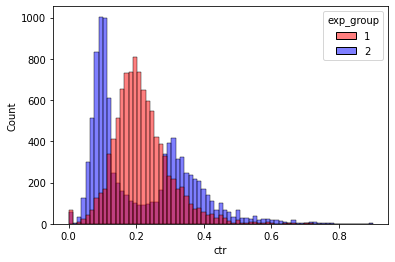

In [9]:
groups = sns.histplot(data = df,
                        x='ctr',
                        hue='exp_group',
                        palette = ['r', 'b'],
                        alpha=0.5,
                        kde=False)

Очевидно что наши данные распределены не нормально, чтобы удостовериться проведем тест Шапиро на нормальность распределения данных, а также проведем тест Левена для определения равенства дисперсии

In [10]:
group_A = df[df['exp_group'] == 1]['ctr']
group_B = df[df['exp_group'] == 2]['ctr']

**Тест Шапиро-Уилка**

In [11]:
# Тест Шапиро-Уилка для группы 1
stats.shapiro(group_A)

# Тест Шапиро-Уилка для группы 2
stats.shapiro(group_B)

/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8931446075439453, pvalue=0.0)

Результаты теста Шапиро-Уилка показывают, что для обеих групп значение p-value равно 0. Это говорит о том, что данные в обеих группах не следуют нормальному распределению

**Тест Левена**

In [12]:
# Тест Левена для проверки равенства дисперсий
stats.levene(group_A, group_B)

LeveneResult(statistic=2757.7940649593234, pvalue=0.0)

В данном случае значение pvalue равно 0.0, что указывает на то, что нулевая гипотеза о равенстве дисперсий с высокой вероятностью отвергается

**T-тест Уэлча**

T-тест Уэлча является вариантом t-теста для двух выборок, который не предполагает равенства дисперсий в этих выборках, что делает его более устойчивым к различиям в дисперсиях и менее чувствительным к отклонениям от нормальности распределения. Кроме того, при очень больших выборках центральная предельная теорема вступает в силу, что означает, что распределение выборочного среднего будет приближаться к нормальному распределению, независимо от формы исходного распределения. Это делает t-тест Уэлча применимым и при ненормальных распределениях, если выборка действительно большая.

In [13]:
stats.ttest_ind(group_A, group_B, equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Не отвергаем нулевую гипотезу. Средние значения выборок не различаются

**Тест Манна-Уитни**

In [14]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Тест Манна-Уитни увидел разницу между распределениями CTR в двух группах, следовательно отвергаем нулевую гипотезу. Выбороки различаются

**T-тест на сглаженном CTR**

In [21]:
def get_smoothed_ctr(user_likes: int, 
                    user_views: int, 
                    global_ctr: float, 
                    alpha: float) -> float:

    '''
    Вычисляет сглаженный CTR (Click-Through Rate) на основе данных пользователя и глобального CTR.

    Параметры:
    -----------
    user_likes : int
        Количество лайков, поставленных пользователем.
    user_views : int
        Количество просмотров, совершенных пользователем.
    global_ctr : float
        Глобальный CTR, используемый для сглаживания.
    alpha : int или float
        Коэффициент сглаживания, который регулирует баланс между пользовательскими и глобальными данными.

    Возвращает:
    ----------
    float
        Сглаженное значение CTR, вычисленное на основе введенных параметров.
    '''
    
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [22]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [23]:
control = df[df.exp_group == 1].copy()
test = df[df.exp_group == 2].copy()

In [24]:
control['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [25]:
test['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [26]:
stats.ttest_ind(control.smoothed_ctr,
                test.smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

Т-тест на сглаженном CTR не показал статистически значимых различий между средними сглаженными CTR в двух группах. Хотя у нас все еще нет теоретической гарантии, что направленность сглаженного CTR совпадает с направленностью общего количества лайков.

**Пуассоновский бутстреп**

In [27]:
def bootstrap(likes1: np.ndarray, 
              views1: np.ndarray, 
              likes2: np.ndarray, 
              views2: np.ndarray, 
              n_bootstrap: int = 2000) -> tuple:
    '''
    Выполняет бутстрап-процедуру для оценки доверительных интервалов для CTR двух групп.

    Параметры:
    -----------
    likes1 : np.ndarray
        Массив с количеством лайков для первой группы.
    views1 : np.ndarray
        Массив с количеством просмотров для первой группы.
    likes2 : np.ndarray
        Массив с количеством лайков для второй группы.
    views2 : np.ndarray
        Массив с количеством просмотров для второй группы.
    n_bootstrap : int, optional (default = 2000)
        Количество бутстрап-итераций для оценки.

    Возвращает:
    ----------
    Tuple
        Два массива, содержащих оцененные значения глобального CTR для первой и второй группы на основе бутстрапа.
    '''

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [28]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

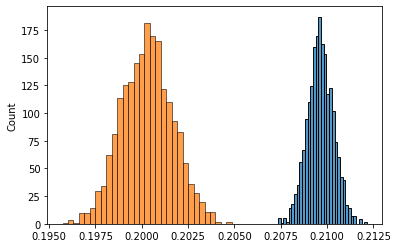

In [29]:
sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

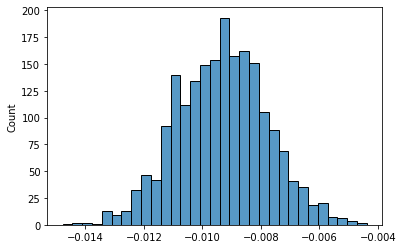

In [30]:
sns.histplot(ctr2 - ctr1) 

Данный метод показал статистичеки значимую разницу между CTR двух групп. Гистограмма разности не пересекает 0, разница между группами отрицательная, значит, контрольная группа показала лучший результат по CTR, чем тестовая группа.

**T-тест поверх бакетного преобразования**

In [31]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2024-09-27' and '2024-10-03'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_b = ph.read_clickhouse(q, connection=connection)
df_b.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.200592
1,2,0,0.196510
2,1,1,0.208799
3,2,1,0.210375
4,1,2,0.204632


In [32]:
stats.ttest_ind(df_b[df_b.exp_group == 1].bucket_ctr,
                df_b[df_b.exp_group == 2].bucket_ctr,
                equal_var=False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

In [33]:
df_b.groupby('exp_group')['bucket_ctr'].mean() 

exp_group
1    0.209694
2    0.200457
Name: bucket_ctr, dtype: float64

T-тест поверх бакетного преобразования показал,что средние побакетные CTR в группах различаются. Т.е. средний побакетный CTR в контрольной группе выше, чем в тестовой.

Моя рекомендация — не раскатывать новый алгоритм на всех пользователей сразу, так как он оказал в большинстве своем отрицательный эффект. Необходимо провести дальнейшие исследования, чтобы понять причину различий в распределениях и определить, стоит ли алгоритм применять, и для каких конкретных пользователей он может быть полезен.